In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.ensemble._iforest import _average_path_length
import shap
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', None)

# Loading combined fbref/ transfermarkt data

In [2]:
df = pd.read_parquet(os.path.join('data', 'fbref_tm_combined.parquet'))

In [3]:
# Drop some negative columns that you might not want to identify players based on, e.g. number of yellow cards.
# penalties are rare so they tend to show up a lot in the outliers so removed for showing more interesting things
to_drop = ['performance_off', 'performance_crdy', 'performance_2crdy', 'performance_crdr', 'performance_fls',
           'performance_og', 'performance_pkcon', 'performance_pkwon', 'standard_fk', 'pass_types_fk', 'vs_dribbles_att',
           'outcomes_off', 'outcomes_out', 'outcomes_int', 'outcomes_blocks', 'standard_pk', 'playing_time_mn/mp', 'short_att',
           'pass_types_press', 'body_parts_right', 'body_parts_other', 'body_parts_head', 'a-xa', 'expected_np:g-xg',
           'aerial_duels_lost', 'carries_mis', 'carries_dis', 'err', 'standard_pkatt']
df.drop(to_drop, axis='columns', inplace=True)
# drop gca_types_gca_og_for as usually very low (mostly 0, but ocassionally 1 or 2)
df.drop('gca_types_og', axis='columns', inplace=True)

# Drop centre backs / goalkeepers

Centre-back stats are notoriously hard and goalkeepers are judged differently so we drop them here.

In [4]:
mask_remove = (((df.position_tm == 'Centre-Back') | (df.position_tm == 'Goalkeeper')) &
               ((df.pos.str.contains('GK')) | (df.pos.str.contains('DF'))))
df = df[~mask_remove].copy()

# Drop players with fewer than 675 minutes played over last 3 years

This is an arbitrary cut-off point (around 7.5 games)

In [5]:
# commented out as already done in the third notebook
#df = df[df.playing_time_min >= 675].copy()
#df.reset_index(drop=True, inplace=True)

# Add a code for the transfermarkt position

Note there is some disagreement between fbref and transfermarkt positions but it is broadly the same

In [6]:
df.loc[df.position_tm.str.contains('Midfield'), 'position_code'] = 0
df.loc[df.position_tm.str.contains('Back'), 'position_code'] = 1
df.loc[df.position_tm.str.contains('Striker'), 'position_code'] = 2
df.loc[df.position_tm.str.contains('Winger'), 'position_code'] = 2
df.loc[df.position_tm.str.contains('Forward'), 'position_code'] = 2

# Remove one player (Salva Ferrer) whose data is mostly missing

In [7]:
df = df[df.player_tm != 'Salva Ferrer'].copy()

# Reset the index

In [8]:
df.reset_index(drop=True, inplace=True)

# Check for highly correlated columns and drop them

In [9]:
corr_cols = ['pass_types_live', 'medium_att', 'total_att', 'receiving_rec', 'long_att', 'medium_cmp%', 'pass_types_crs',
             'touches_def_pen',  'tackles_tkl', 'vs_dribbles_past','blocks_pass',  'body_parts_ti',  'tackles_mid_3rd', 
             'prog', 'expected_xg','standard_sh',  'standard_g/sot',  'expected_g-xg', 'kp', 'sca_types_passlive',
             'team_success_+/-','gca_types_passlive', 'team_success_ong', 'dribbles_#pl', 'carries_totdist', 'medium_cmp',
             'total_cmp','tkl+int', 'team_success_(xg)_onxg', 'standard_sot', 'height_ground', 'touches_mid_3rd',
             'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_str', 'touches_def_3rd', 'team_success_onga', 'dribbles_succ',
             'gca_gca','gca_types_passdead', 'sca_sca', 'standard_gls', 'ast', 'pass_types_dead', 'receiving_rec%',
             'gca_types_drib', 'gca_types_sh', 'gca_types_fld', 'short_cmp%', 'total_totdist', 'total_cmp%', 'height_low',
             'expected_npxg+xa', 'performance_g-pk',  'touches_att_pen', 'carries_1/3', 'carries_prgdist',
             'long_cmp', 'touches_live', 'dribbles_att', 'pass_types_ck', 'pressures_press', 'touches_touches']

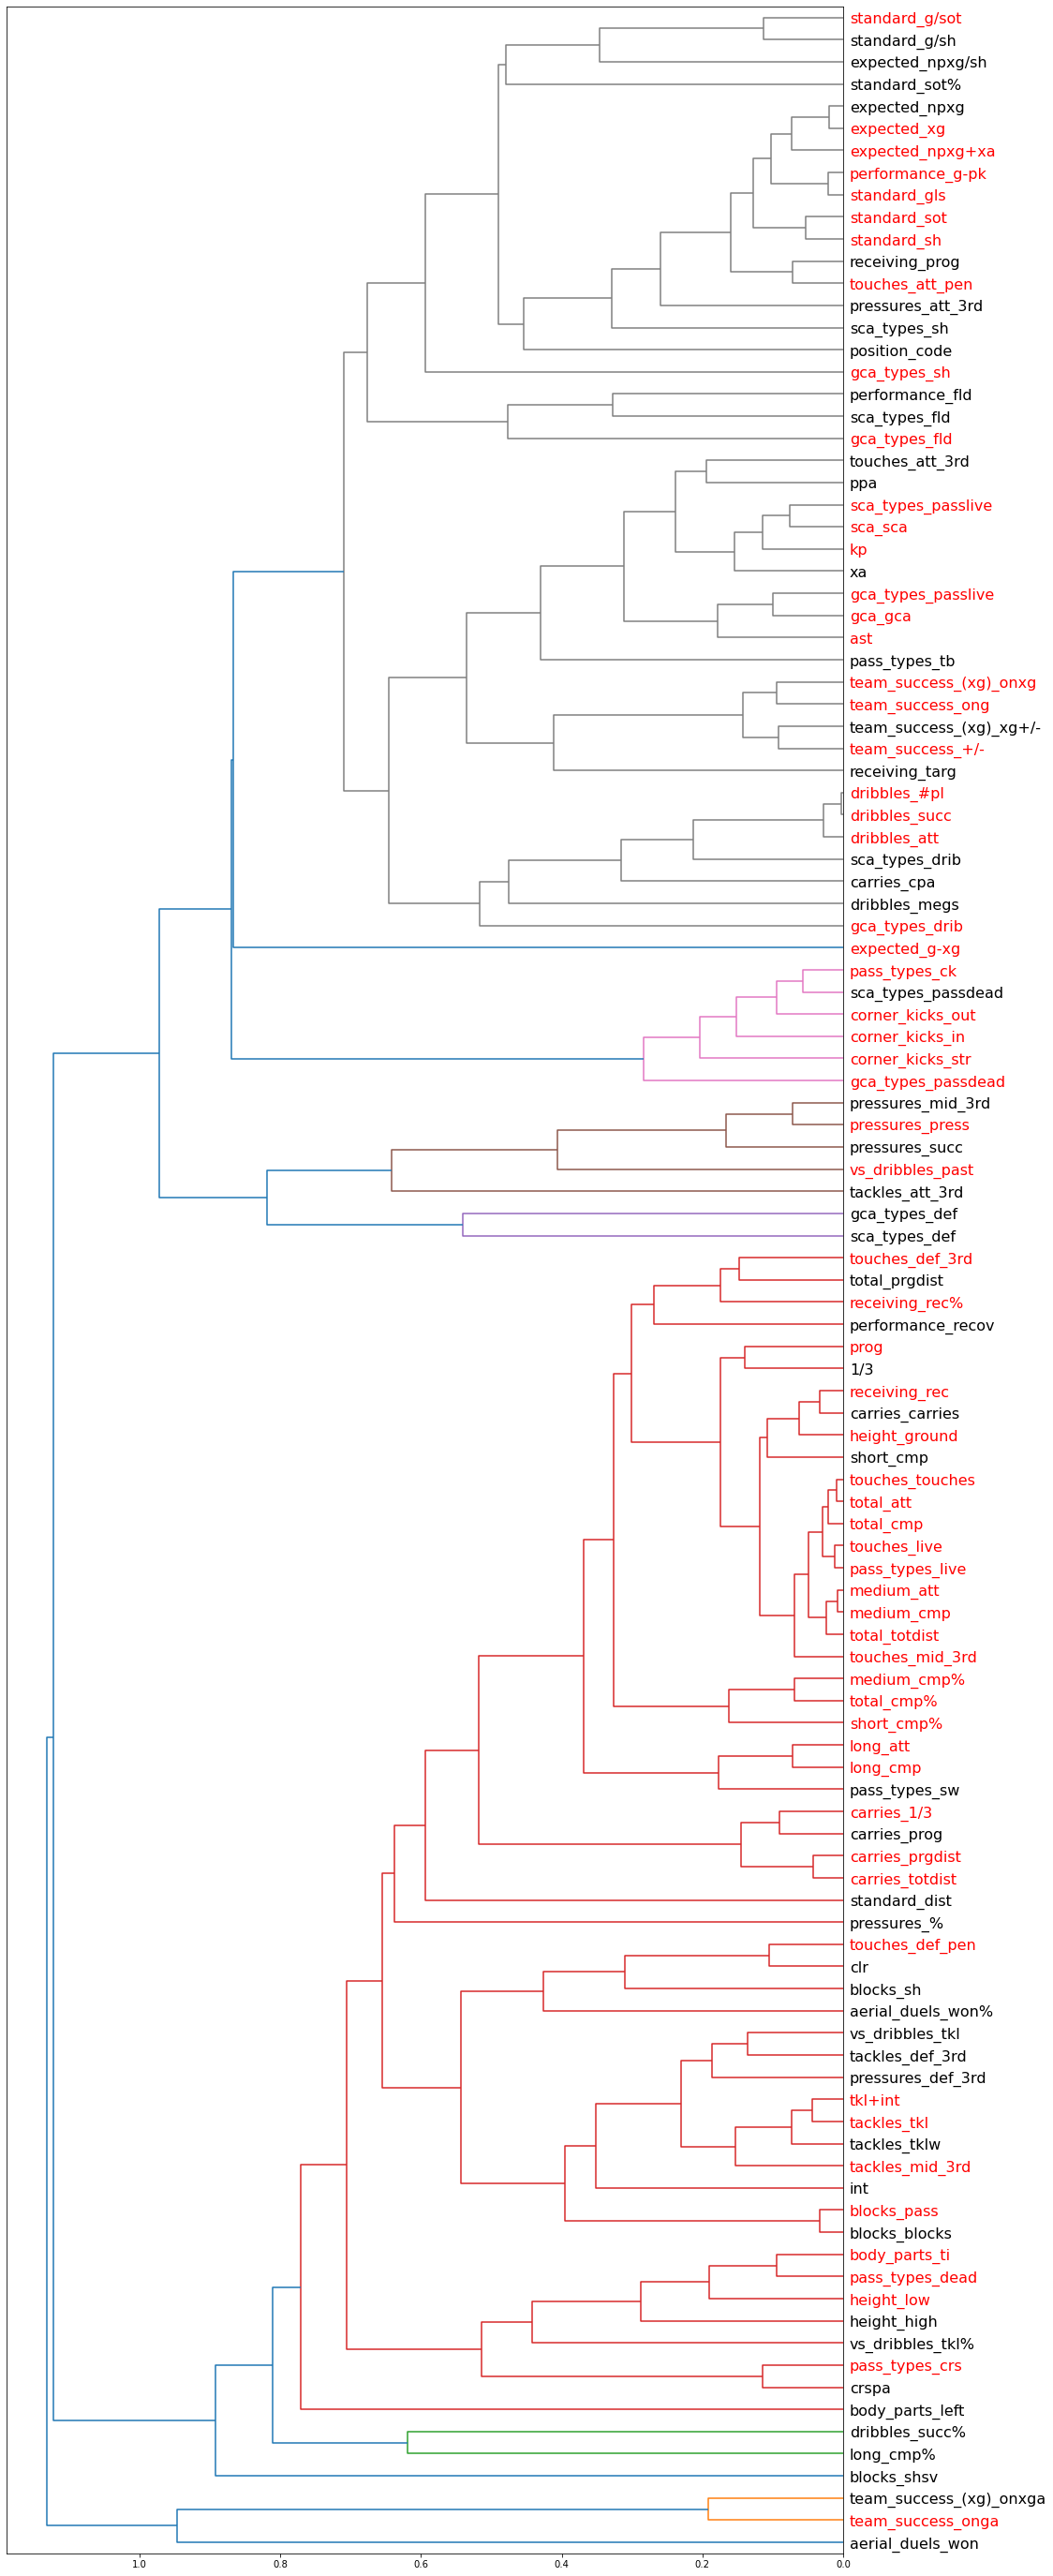

In [10]:
# https://stackoverflow.com/questions/34175462/dendrogram-using-pandas-and-scipy
corr_condensed = squareform(1 - df[df.columns[29:]].corr())
z = linkage(corr_condensed, method='average')
fig, ax = plt.subplots(figsize=(16, 50))
labels = list(df[df.columns[29:]].columns)
dend = dendrogram(z, orientation='left', labels=labels, leaf_font_size=16, ax=ax)
for label in ax.get_yticklabels():
    if label.get_text() in corr_cols:
        label.set_color('red')

In [11]:
df.drop(corr_cols, axis='columns', inplace=True)

In [12]:
print('Columns left:', len(df.columns[29:]))
list(df.columns[29:])

Columns left: 52


['team_success_(xg)_onxga',
 'team_success_(xg)_xg+/-',
 'tackles_tklw',
 'tackles_def_3rd',
 'tackles_att_3rd',
 'vs_dribbles_tkl',
 'pressures_succ',
 'pressures_def_3rd',
 'pressures_mid_3rd',
 'pressures_att_3rd',
 'blocks_blocks',
 'blocks_sh',
 'blocks_shsv',
 'int',
 'clr',
 'sca_types_passdead',
 'sca_types_drib',
 'sca_types_sh',
 'sca_types_fld',
 'sca_types_def',
 'gca_types_def',
 'performance_fld',
 'performance_recov',
 'aerial_duels_won',
 'total_prgdist',
 'short_cmp',
 'xa',
 '1/3',
 'ppa',
 'crspa',
 'pass_types_tb',
 'pass_types_sw',
 'height_high',
 'body_parts_left',
 'touches_att_3rd',
 'dribbles_megs',
 'carries_carries',
 'carries_prog',
 'carries_cpa',
 'receiving_targ',
 'receiving_prog',
 'expected_npxg',
 'standard_dist',
 'vs_dribbles_tkl%',
 'pressures_%',
 'aerial_duels_won%',
 'long_cmp%',
 'dribbles_succ%',
 'standard_g/sh',
 'expected_npxg/sh',
 'standard_sot%',
 'position_code']

# Change some values as we don't want to flag people as outliers for their poor stats (truncate stats for bottom quantile if more is better or top quantile if fewer is better)

In [13]:
X = df[df.columns[29:]].fillna(0)
# for goals allowed stats if in the top 50% change the value
cols_fewer_better = [X.columns[0]]
mask1 = X[cols_fewer_better] > X[cols_fewer_better].quantile(0.5)

In [14]:
X = df[df.columns[29:]]
X_copy = X.copy() # Store copy before modifying
X = X.fillna(0)
# for goals allowed stats if in the top 50% change the value
cols_fewer_better = [X.columns[0]]
mask1 = X[cols_fewer_better] > X[cols_fewer_better].quantile(0.5)
# for other stats is in the bottom quantile change value
cols_more_better = X.columns[1:-1]
mask2 = X[cols_more_better] < X[cols_more_better].quantile(0.25)
mask = pd.concat([mask1, mask2], axis='columns')
quantile_values = pd.concat([X[cols_fewer_better].quantile(0.5), X[cols_more_better].quantile(0.25)])
X.mask(mask, quantile_values, axis='columns', inplace=True)

# Find outliers using isolation forest

In [15]:
clf = IsolationForest(random_state=42, contamination=0.1)
y_pred = clf.fit(X)
forest_score = clf.score_samples(X)

# Calculate shap values (to explain the outliers)

In [16]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
df_shap = pd.DataFrame(shap_values, columns=X.columns)

# Get the column names contributing to the the smallest (most negative) difference and their values

In [17]:
# https://stackoverflow.com/questions/48764923/find-the-column-name-which-has-the-2nd-maximum-value-for-each-row-pandas
sort_arr = np.argsort(df_shap.values, axis=1)
df_stat_name = pd.DataFrame(np.array(df_shap.columns)[sort_arr], index=df_shap.index,
                            columns=[f'stat_{i}_name' for i in range(1, sort_arr.shape[1] + 1)])
# then get values
sort_arr = (sort_arr.T + (np.arange(0, sort_arr.shape[0]) * sort_arr.shape[1])).T
df_stat_values = pd.DataFrame(X_copy.values.ravel()[sort_arr].reshape(X_copy.shape),
                              columns=[f'stat_{i}_value' for i in range(1, sort_arr.shape[1] + 1)])
# merge them together
df_stat_values = df_stat_name.merge(df_stat_values, left_index=True, right_index=True)
# reorder the columns so it goes stat name then value, stat name then value, etc.
col_order = np.repeat(np.arange(sort_arr.shape[1]), 2) + np.tile(np.array([0, sort_arr.shape[1]]), sort_arr.shape[1])
col_order = df_stat_values.columns[col_order]
df_stat_values = df_stat_values[col_order].copy()

# Create final dataframe

In [18]:
df = df[df.columns[:29]].copy()
df['outlier_score'] = forest_score
df = df.merge(df_stat_values, left_index=True, right_index=True, validate='1:1')

# Sort by the score

In [19]:
df.sort_values('outlier_score', inplace=True)
df.reset_index(drop=True, inplace=True)

# Rename some columns

In [20]:
df.rename({'number_tm': 'number_transfermarkt',
           'player_tm': 'player_name_transfermarkt',
           'player': 'player_name_fbref',
           'dob_tm': 'dob_transfermarkt',
           'age_at_2021_04_01_tm': 'age_years_at_2021_04_01_transfermarkt',
           'position_tm': 'position_transfermarkt',
           'pos': 'position_fbref',
           'height_tm': 'height_transfermarkt',
           'foot_tm': 'foot_transfermarkt',
           'squad_tm': 'squad_transfermarkt', 
           'league_tm': 'league_transfermarkt',
           'joined_tm': 'joined_transfermarkt',
           'contract_expires_tm': 'contract_expires_transfermarkt',
           'market_value_euro_millions_tm': 'market_value_euros_millions_transfermarkt', 
           'year_tm': 'year_of_valuation_transfermarkt',
           'player_link_tm': 'player_link_transfermarkt',
           'player_link_fbref': 'player_link_fbref',
           'nation': 'nation_fbref',
           'squad': 'squad_fbref',
           'comp': 'comp_fbref',
           'match_link': 'match_link_fbref',
           'born': 'born_fbref'},
          axis='columns', inplace=True)

# Show top 30 outliers

In [21]:
df.head(30)

,number_transfermarkt,player_name_transfermarkt,position_transfermarkt,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,market_value_euros_millions_transfermarkt,league_transfermarkt,player_link_transfermarkt,year_of_valuation_transfermarkt,dob_transfermarkt,squad_transfermarkt,age_years_at_2021_04_01_transfermarkt,player_link_fbref,player_name_fbref,nation_fbref,position_fbref,squad_fbref,comp_fbref,match_link_fbref,90s,born_fbref,playing_time_mp,playing_time_min,starts_starts,starts_compl,subs_subs,subs_unsub,outlier_score,stat_1_name,stat_1_value,stat_2_name,stat_2_value,stat_3_name,stat_3_value,stat_4_name,stat_4_value,stat_5_name,stat_5_value,stat_6_name,stat_6_value,stat_7_name,stat_7_value,stat_8_name,stat_8_value,stat_9_name,stat_9_value,stat_10_name,stat_10_value,stat_11_name,stat_11_value,stat_12_name,stat_12_value,stat_13_name,stat_13_value,stat_14_name,stat_14_value,stat_15_name,stat_15_value,stat_16_name,stat_16_value,stat_17_name,stat_17_value,stat_18_name,stat_18_value,stat_19_name,stat_19_value,stat_20_name,stat_20_value,stat_21_name,stat_21_value,stat_22_name,stat_22_value,stat_23_name,stat_23_value,stat_24_name,stat_24_value,stat_25_name,stat_25_value,stat_26_name,stat_26_value,stat_27_name,stat_27_value,stat_28_name,stat_28_value,stat_29_name,stat_29_value,stat_30_name,stat_30_value,stat_31_name,stat_31_value,stat_32_name,stat_32_value,stat_33_name,stat_33_value,stat_34_name,stat_34_value,stat_35_name,stat_35_value,stat_36_name,stat_36_value,stat_37_name,stat_37_value,stat_38_name,stat_38_value,stat_39_name,stat_39_value,stat_40_name,stat_40_value,stat_41_name,stat_41_value,stat_42_name,stat_42_value,stat_43_name,stat_43_value,stat_44_name,stat_44_value,stat_45_name,stat_45_value,stat_46_name,stat_46_value,stat_47_name,stat_47_value,stat_48_name,stat_48_value,stat_49_name,stat_49_value,stat_50_name,stat_50_value,stat_51_name,stat_51_value,stat_52_name,stat_52_value
0,10.0,Neymar,Left Winger,1.75,right,2017-08-03,2022-06-30,110.0,Ligue 1,/neymar/profil/spieler/68290,2020,1992-02-05,Paris S-G,29.2,/en/players/69384e5d/Neymar,Neymar,br BRA,"MF,FW",Paris S-G,fr Ligue 1,/en/players/69384e5d/matchlogs/2020-2021/summa...,41.4,1992.0,45.0,3733.0,41.0,30.0,4.0,0.0,-0.624719,xa,0.359,performance_fld,4.123,pass_types_tb,1.157,carries_prog,14.080,team_success_(xg)_xg+/-,1.514,ppa,4.316,sca_types_drib,0.747,1/3,7.643,carries_carries,72.569,receiving_targ,83.153,sca_types_fld,0.747,touches_att_3rd,45.784,expected_npxg,0.547,dribbles_megs,0.651,receiving_prog,12.272,sca_types_passdead,0.771,sca_types_sh,0.313,carries_cpa,1.374,short_cmp,27.075,team_success_(xg)_onxga,0.940,standard_g/sh,0.150,expected_npxg/sh,0.150,total_prgdist,317.375,height_high,9.330,pressures_mid_3rd,5.834,pressures_succ,3.544,sca_types_def,0.000,vs_dribbles_tkl,0.265,tackles_tklw,0.506,pressures_%,28.400,pressures_att_3rd,5.497,dribbles_succ%,57.400,int,0.338,blocks_blocks,0.796,performance_recov,6.051,standard_sot%,42.400,standard_dist,18.400,pass_types_sw,1.905,aerial_duels_won%,44.800,vs_dribbles_tkl%,14.900,tackles_att_3rd,0.193,crspa,0.265,gca_types_def,0.000,blocks_shsv,0.000,body_parts_left,9.041,long_cmp%,56.000,blocks_sh,0.000,tackles_def_3rd,0.121,aerial_duels_won,0.313,clr,0.048,pressures_def_3rd,1.133,position_code,2.000
1,17.0,Kevin De Bruyne,Attacking Midfield,1.81,right,2015-08-30,2025-06-30,100.0,Premier League,/kevin-de-bruyne/profil/spieler/88755,2020,1991-06-28,Manchester City,29.8,/en/players/e46012d4/Kevin-De-Bruyne,Kevin De Bruyne,be BEL,MF,Manchester City,eng Premier League,/en/players/e46012d4/matchlogs/2020-2021/summa...,63.0,1991.0,78.0,5673.0,65.0,40.0,13.0,4.0,-0.611947,xa,0.492,pass_types_tb,0.968,ppa,3.792,team_success_(xg)_xg+/-,1.485,sca_types_passdead,1.111,touches_att_3rd,44.516,pass_types_sw,3.696,receiving_targ,69.582,carries_prog,10.201,team_success_(xg)_onxga,0.793,sca_types_def,0.143,1/3,5.695,position_code,0.000,pressures_att_3rd,7.726,height_high,13.136,crspa,0.555,sc

# Show top 30 outliers aged 26 or under and valued at 15 mill or under

In [22]:
df[(df.age_years_at_2021_04_01_transfermarkt <= 26) & (df.market_value_euros_millions_transfermarkt <= 15)].head(30)

,number_transfermarkt,player_name_transfermarkt,position_transfermarkt,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,market_value_euros_millions_transfermarkt,league_transfermarkt,player_link_transfermarkt,year_of_valuation_transfermarkt,dob_transfermarkt,squad_transfermarkt,age_years_at_2021_04_01_transfermarkt,player_link_fbref,player_name_fbref,nation_fbref,position_fbref,squad_fbref,comp_fbref,match_link_fbref,90s,born_fbref,playing_time_mp,playing_time_min,starts_starts,starts_compl,subs_subs,subs_unsub,outlier_score,stat_1_name,stat_1_value,stat_2_name,stat_2_value,stat_3_name,stat_3_value,stat_4_name,stat_4_value,stat_5_name,stat_5_value,stat_6_name,stat_6_value,stat_7_name,stat_7_value,stat_8_name,stat_8_value,stat_9_name,stat_9_value,stat_10_name,stat_10_value,stat_11_name,stat_11_value,stat_12_name,stat_12_value,stat_13_name,stat_13_value,stat_14_name,stat_14_value,stat_15_name,stat_15_value,stat_16_name,stat_16_value,stat_17_name,stat_17_value,stat_18_name,stat_18_value,stat_19_name,stat_19_value,stat_20_name,stat_20_value,stat_21_name,stat_21_value,stat_22_name,stat_22_value,stat_23_name,stat_23_value,stat_24_name,stat_24_value,stat_25_name,stat_25_value,stat_26_name,stat_26_value,stat_27_name,stat_27_value,stat_28_name,stat_28_value,stat_29_name,stat_29_value,stat_30_name,stat_30_value,stat_31_name,stat_31_value,stat_32_name,stat_32_value,stat_33_name,stat_33_value,stat_34_name,stat_34_value,stat_35_name,stat_35_value,stat_36_name,stat_36_value,stat_37_name,stat_37_value,stat_38_name,stat_38_value,stat_39_name,stat_39_value,stat_40_name,stat_40_value,stat_41_name,stat_41_value,stat_42_name,stat_42_value,stat_43_name,stat_43_value,stat_44_name,stat_44_value,stat_45_name,stat_45_value,stat_46_name,stat_46_value,stat_47_name,stat_47_value,stat_48_name,stat_48_value,stat_49_name,stat_49_value,stat_50_name,stat_50_value,stat_51_name,stat_51_value,stat_52_name,stat_52_value
53,15.0,Javi Ontiveros,Left Winger,1.75,right,2020-09-24,2021-06-30,6.0,LaLiga,/javi-ontiveros/profil/spieler/298983,2020,1997-09-09,Huesca,23.6,/en/players/a83d8b0c/Javier-Ontiveros,Javier Ontiveros,es ESP,"FW,MF",Huesca,es La Liga,/en/players/a83d8b0c/matchlogs/2020-2021/summa...,20.1,1997.0,50.0,1807.0,17.0,4.0,33.0,12.0,-0.517370,sca_types_drib,0.847,carries_prog,11.704,dribbles_megs,0.299,carries_cpa,1.843,sca_types_fld,0.448,tackles_tklw,2.042,performance_fld,2.640,standard_dist,24.700,pass_types_tb,0.299,carries_carries,51.599,touches_att_3rd,27.144,position_code,2.000,crspa,0.398,receiving_prog,5.429,pressures_succ,5.927,sca_types_passdead,0.498,pass_types_sw,2.092,long_cmp%,52.100,pressures_mid_3rd,10.609,vs_dribbles_tkl,0.946,pressures_def_3rd,7.371,xa,0.149,short_cmp,19.524,tackles_def_3rd,1.146,performance_recov,8.467,receiving_targ,55.883,aerial_duels_won%,25.000,pressures_%,26.200,pressures_att_3rd,4.682,ppa,1.245,expected_npxg/sh,0.040,total_prgdist,179.851,standard_g/sh,0.040,1/3,2.939,standard_sot%,32.500,tackles_att_3rd,0.249,gca_types_def,0.000,dribbles_succ%,57.700,blocks_shsv,0.000,team_success_(xg)_onxga,1.305,sca_types_sh,0.100,blocks_blocks,1.195,height_high,8.218,vs_dribbles_tkl%,26.400,int,0.847,team_success_(xg)_xg+/-,-0.120,expected_npxg,0.159,blocks_sh,0.050,aerial_duels_won,0.498,body_parts_left,5.230,clr,0.697,sca_types_def,0.050
54,25.0,Maxence Caqueret,Central Midfield,1.74,right,2018-12-14,2023-06-30,15.0,Ligue 1,/maxence-caqueret/profil/spieler/395237,2020,2000-02-15,Lyon,21.1,/en/players/f81ef10d/Maxence-Caqueret,Maxence Caqueret,fr FRA,MF,Lyon,fr Ligue 1,/en/players/f81ef10d/matchlogs/2020-2021/summa...,22.5,2000.0,33.0,2026.0,22.0,13.0,11.0,18.0,-0.516283,pressures_mid_3rd,17.014,pressures_succ,9.195,tackles_tklw,2.710,team_success_(xg)_xg+/-,0.857,1/3,5.153,pressures_att_3rd,6.841,tackles_att_3rd,0.711,blocks_blocks,2.266,long_cmp%,81.500,team_success_(xg)_onxga,0.942,receiving_targ,53.796,vs_dribbles_tkl,1.155,ppa,1.466,total_prgdist,275.908,short_cmp,21.900,standar

# Show older outliers with a low valuation

In [23]:
df[(df.market_value_euros_millions_transfermarkt < 5) & (df.age_years_at_2021_04_01_transfermarkt > 26) & 
   (df.age_years_at_2021_04_01_transfermarkt < 30)].head(15)

,number_transfermarkt,player_name_transfermarkt,position_transfermarkt,height_transfermarkt,foot_transfermarkt,joined_transfermarkt,contract_expires_transfermarkt,market_value_euros_millions_transfermarkt,league_transfermarkt,player_link_transfermarkt,year_of_valuation_transfermarkt,dob_transfermarkt,squad_transfermarkt,age_years_at_2021_04_01_transfermarkt,player_link_fbref,player_name_fbref,nation_fbref,position_fbref,squad_fbref,comp_fbref,match_link_fbref,90s,born_fbref,playing_time_mp,playing_time_min,starts_starts,starts_compl,subs_subs,subs_unsub,outlier_score,stat_1_name,stat_1_value,stat_2_name,stat_2_value,stat_3_name,stat_3_value,stat_4_name,stat_4_value,stat_5_name,stat_5_value,stat_6_name,stat_6_value,stat_7_name,stat_7_value,stat_8_name,stat_8_value,stat_9_name,stat_9_value,stat_10_name,stat_10_value,stat_11_name,stat_11_value,stat_12_name,stat_12_value,stat_13_name,stat_13_value,stat_14_name,stat_14_value,stat_15_name,stat_15_value,stat_16_name,stat_16_value,stat_17_name,stat_17_value,stat_18_name,stat_18_value,stat_19_name,stat_19_value,stat_20_name,stat_20_value,stat_21_name,stat_21_value,stat_22_name,stat_22_value,stat_23_name,stat_23_value,stat_24_name,stat_24_value,stat_25_name,stat_25_value,stat_26_name,stat_26_value,stat_27_name,stat_27_value,stat_28_name,stat_28_value,stat_29_name,stat_29_value,stat_30_name,stat_30_value,stat_31_name,stat_31_value,stat_32_name,stat_32_value,stat_33_name,stat_33_value,stat_34_name,stat_34_value,stat_35_name,stat_35_value,stat_36_name,stat_36_value,stat_37_name,stat_37_value,stat_38_name,stat_38_value,stat_39_name,stat_39_value,stat_40_name,stat_40_value,stat_41_name,stat_41_value,stat_42_name,stat_42_value,stat_43_name,stat_43_value,stat_44_name,stat_44_value,stat_45_name,stat_45_value,stat_46_name,stat_46_value,stat_47_name,stat_47_value,stat_48_name,stat_48_value,stat_49_name,stat_49_value,stat_50_name,stat_50_value,stat_51_name,stat_51_value,stat_52_name,stat_52_value
18,92.0,Jean-Daniel Akpa Akpro,Central Midfield,1.80,right,2020-09-18,2024-06-30,3.5,Serie A,/jean-daniel-akpa-akpro/profil/spieler/170481,2020,1992-10-11,Lazio,28.5,/en/players/fdf4b948/Jean-Daniel-Akpa-Akpro,Jean-Daniel Akpa-Akpro,ci CIV,"MF,FW",Lazio,it Serie A,/en/players/fdf4b948/matchlogs/2020-2021/summa...,9.4,1992.0,25.0,849.0,4.0,2.0,21.0,4.0,-0.537762,sca_types_def,0.318,blocks_blocks,2.968,blocks_sh,0.636,pressures_succ,9.223,pressures_mid_3rd,14.205,dribbles_megs,0.424,tackles_tklw,2.862,int,1.590,dribbles_succ%,78.300,tackles_def_3rd,1.484,pressures_%,32.200,pass_types_tb,0.212,team_success_(xg)_onxga,1.177,expected_npxg/sh,NaN,pressures_def_3rd,8.693,tackles_att_3rd,0.424,carries_carries,29.258,long_cmp%,72.400,pressures_att_3rd,5.724,sca_types_fld,0.106,carries_prog,2.650,xa,0.095,height_high,3.074,standard_sot%,NaN,team_success_(xg)_xg+/-,0.148,ppa,0.848,1/3,1.696,pass_types_sw,0.636,aerial_duels_won%,50.000,position_code,0.000,standard_dist,17.900,total_prgdist,88.834,vs_dribbles_tkl,0.848,receiving_targ,30.530,performance_recov,8.163,receiving_prog,3.392,gca_types_def,0.000,short_cmp,12.721,touches_att_3rd,12.615,vs_dribbles_tkl%,36.400,blocks_shsv,0.000,clr,1.060,standard_g/sh,NaN,carries_cpa,0.212,sca_types_sh,0.000,aerial_duels_won,0.636,sca_types_drib,0.106,performance_fld,1.060,sca_types_passdead,0.000,crspa,0.000,body_parts_left,5.088,expected_npxg,0.053
24,6.0,Laurent Abergel,Defensive Midfield,1.70,right,2019-07-26,2023-06-30,2.5,Ligue 1,/laurent-abergel/profil/spieler/238626,2020,1993-02-01,Lorient,28.2,/en/players/31626657/Laurent-Abergel,Laurent Abergel,fr FRA,MF,Lorient,fr Ligue 1,/en/players/31626657/matchlogs/2020-2021/summa...,27.9,1993.0,33.0,2513.0,27.0,17.0,6.0,0.0,-0.532544,pressures_mid_3rd,15.937,vs_dribbles_tkl,1.576,pressures_succ,8.237,tackles_def_3rd,1.862,sca_types_def,0.179,tackles_tklw,3.295,gca_types_def,0.036,pressures_def_3rd,9.526,standard_dist,25.700,tackles_att_3rd,0.537,sca_types_sh,0.143,standard_g/sh,0.120,int,1.468,position_code,0.000,standard_sot%,3

# Save to excel

In [24]:
df.to_excel(os.path.join('data', 'outliers.xlsx'))